<a href="https://colab.research.google.com/github/nurinbat/project_wid3006/blob/main/cat_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

# Simple audio recognition: Recognizing emotion of a cat

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1KYpKCm3sk7-_9hs5Adtwtv9bLUVUh7eU#scrollTo=CNbqmZy0gbyE/cat_emotion.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/nurinbat/project_wid3006.git">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

## Setup

Import necessary modules and dependencies.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the Speech Commands dataset

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [119]:
data_dir = pathlib.Path('/content/gdrive/My Drive/dataset/dataset')

Check basic statistics about the dataset.

In [120]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['WaitingForFood' 'Isolation' 'Brushing']


Extract the audio files into a list and shuffle it.

In [121]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples for label(WaitingForFood):',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 440
Number of examples for label(WaitingForFood): 92
Example file tensor: tf.Tensor(b'/content/gdrive/My Drive/dataset/dataset/Isolation/I_BLE01_EU_FN_DEL01_101.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [122]:
train_files = filenames[:352]
val_files = filenames[352: 352 + 44]
test_files = filenames[-44:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 352
Validation set size 44
Test set size 44


## Reading audio files and their labels

The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

To load an audio file, you will use [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. 
Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in `mini_speech_commands`, the values range from -32768 to 32767. 
The sample rate for this dataset is 16kHz.
Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0].

In [123]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [124]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [125]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [126]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

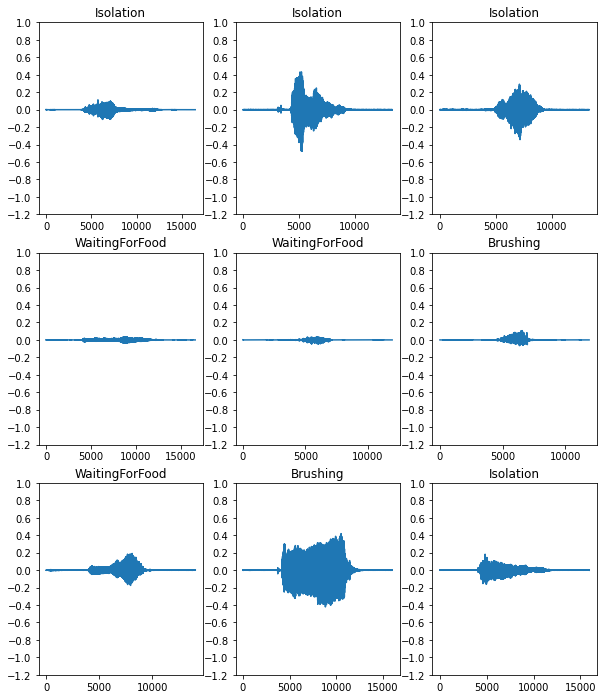

In [127]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. 


In [128]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  # zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  # equal_length = tf.concat([waveform, zero_padding], 0)
  # spectrogram = tf.signal.stft(
  #     equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.signal.stft(
    waveform, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [129]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: Isolation
Waveform shape: (16469,)
Spectrogram shape: (127, 129)
Audio playback


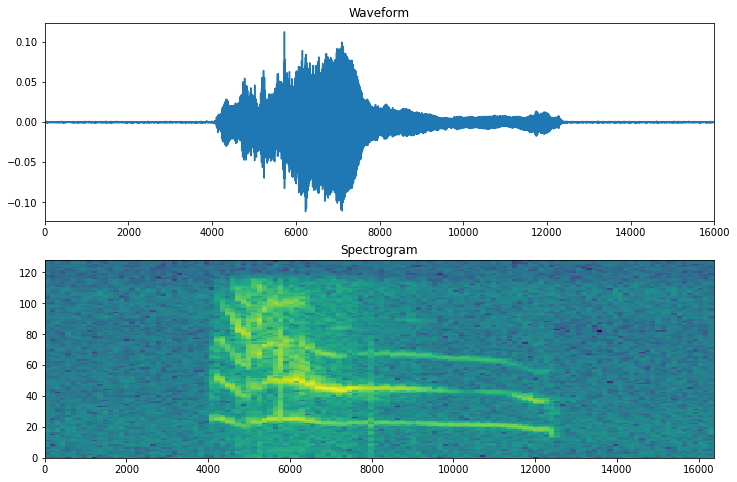

In [130]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [131]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [132]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examine the spectrogram "images" for different samples of the dataset.

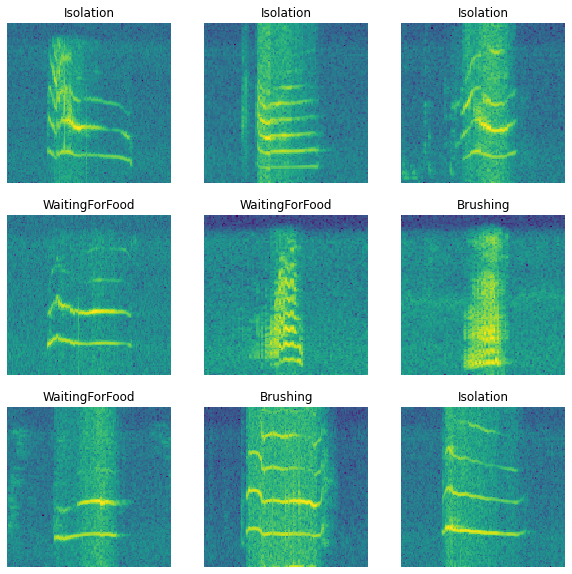

In [133]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [149]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [150]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [151]:
batch_size = 44
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [152]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [153]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (127, 129, 1)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_10 (Resizing)       (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_13 (Normalizat (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)      

In [154]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [155]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=0, patience=2),
)
# history = model.fit(train_ds, validation_data=val_ds,)

Epoch 1/10


InvalidArgumentError: ignored

Let's check the training and validation loss curves to see how your model has improved during training.

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [156]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [157]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

ValueError: ignored

### Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of one of the emotion. How well does your model perform?

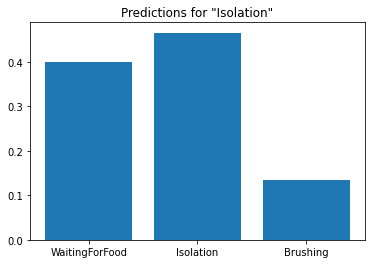

In [158]:
# sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'
# sample_file = data_dir/'WaitingForFood/F_BAC01_MC_MN_SIM01_101.wav'
sample_file = data_dir/'Isolation/I_ANI01_MC_FN_SIM01_101.wav'


sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()